In [ ]:
#@title Install requirements
!pip install alexnet_pytorch
!pip install torchextractor

In [ ]:
#@title Data download
%%capture
!wget -qO rdms.zip https://osf.io/dsnq6/download
!unzip -o rdms
!wget -qO affordances.zip https://osf.io/zcgub/download
!unzip -o affordances

In [ ]:
#@title Imports
import glob
import numpy as np
import urllib
import torch
import cv2
import argparse
import time
import random
import matplotlib.pyplot as plt
import nibabel as nib
import pickle
from tqdm import tqdm
from PIL import Image
from torchvision import transforms as trn
import scipy.io as sio
import h5py
import os
from PIL import Image
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable as V
from sklearn.decomposition import PCA, IncrementalPCA
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from alexnet_pytorch import AlexNet
import torchextractor as tx
import torchvision.transforms as transforms

def loadmat(matfile):
    """Function to load .mat files.
    Parameters
    ----------
    matfile : str
        path to `matfile` containing fMRI data for a given trial.
    Returns
    -------
    dict
        dictionary containing data in key 'vol' for a given trial.
    """
    try:
        f = h5py.File(matfile)
    except (IOError, OSError):
        return sio.loadmat(matfile)
    else:
        return {name: np.transpose(f.get(name)) for name in f.keys()}

In [ ]:
#@title Get names
trajs = loadmat('Trajs.mat')['Trajs']
fnames = trajs.dtype.names # filenames get loaded as custom dtypes due and type of array is initialy np.void due to peculiarites of how it was saved in Matlab.
trajs = np.asarray(trajs[0][0].tolist()) # turn np.void into float32\
stim_fnames = [a.split('.')[0] for a in os.listdir('stimuli')]
fnames_exp_mask = [True if a in stim_fnames else False for a in fnames] #  make a boolean mask to select trajectories for images, 
fnames_exp = np.array(fnames)[fnames_exp_mask] # same order as affordances
print(fnames_exp)
 

['pathways0220' 'pathways0035' 'pathways0011' 'pathways0084'
 'pathways0093' 'pathways0036' 'pathways0242' 'pathways0069'
 'pathways0055' 'pathways0239' 'pathways0180' 'pathways0225'
 'pathways0096' 'pathways0176' 'pathways0014' 'pathways0222'
 'pathways0174' 'pathways0076' 'pathways0150' 'pathways0197'
 'pathways0226' 'pathways0143' 'pathways0047' 'pathways0205'
 'pathways0187' 'pathways0241' 'pathways0238' 'pathways0073'
 'pathways0182' 'pathways0206' 'pathways0010' 'pathways0028'
 'pathways0037' 'pathways0024' 'pathways0224' 'pathways0230'
 'pathways0068' 'pathways0196' 'pathways0087' 'pathways0212'
 'pathways0065' 'pathways0154' 'pathways0218' 'pathways0061'
 'pathways0181' 'pathways0210' 'pathways0116' 'pathways0199'
 'pathways0219' 'pathways0189']


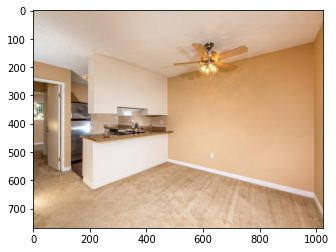

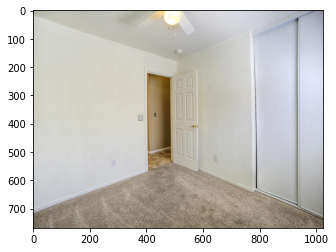

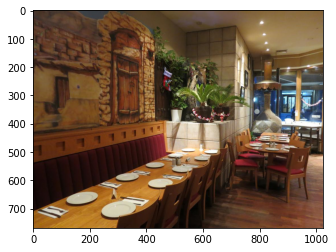

torch.Size([50, 3, 224, 224])


In [ ]:
#@title Get images 
images = [Image.open(f'stimuli/{a}.jpg') for a in fnames_exp]

# Preprocess image
preprocess = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
imgs = [preprocess(img).unsqueeze(0) for img in images]
input_batch = torch.cat(imgs)
print(input_batch.shape)



In [ ]:
#@title Extract features from Alexnet
model = AlexNet.from_pretrained("alexnet")
print(model.parameters)
module_filter_fn = lambda module, name: isinstance(module, torch.nn.ReLU) 
model = tx.Extractor(model, module_filter_fn=module_filter_fn)
#model = tx.Extractor(model, ["layer1", "layer2", "layer3", "layer4"])
model_output, features = model(input_batch)
features.keys()

Loaded pretrained weights for alexnet
<bound method Module.parameters of AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.2, inplace

dict_keys(['features.1', 'features.4', 'features.7', 'features.9', 'features.11', 'classifier.2', 'classifier.5'])

In [ ]:
#@title Function to calculate RDM
def process(x):
  if len(list(x.size()))>1:
    x=torch.flatten(x, start_dim=1, end_dim=-1).tolist()
    pca = PCA(n_components=45)
    x=torch.tensor(pca.fit_transform(x))
    x=torch.flatten(x)
  x=(x-torch.mean(x))/torch.std(x)
  return x

def RDM(feature):
  out=np.zeros((50,50))
  feature_list=[process(feature[i]) for i in range(50)]
  for i in range(50):
    for j in range(50):
      out[i][j]=(torch.sum((feature_list[i]-feature_list[j])**2)/feature_list[i].shape[0]).item()
  return out

(50, 55, 55)


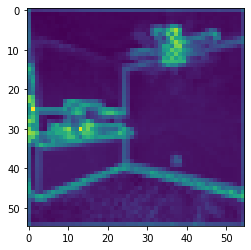

(50, 55, 55)


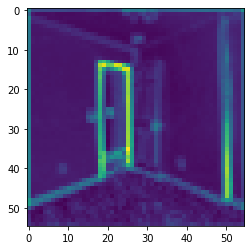

(50, 55, 55)


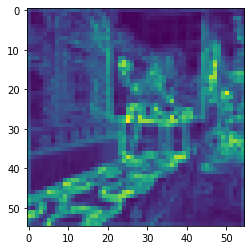

model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.features.1


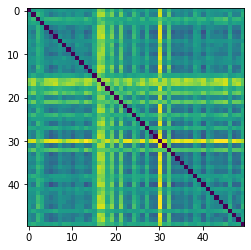

model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.features.4


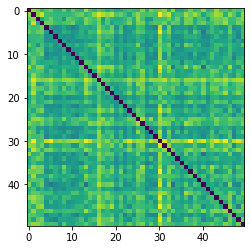

model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.features.7


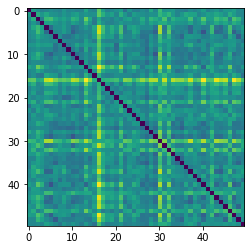

model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.features.9


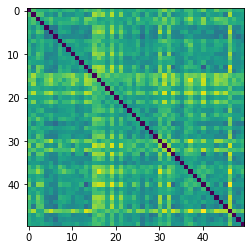

model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.features.11


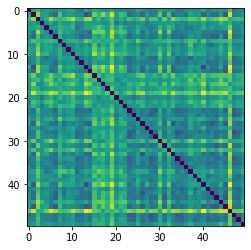

model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.classifier.2


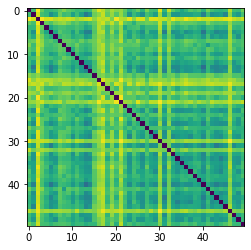

model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.model.classifier.5


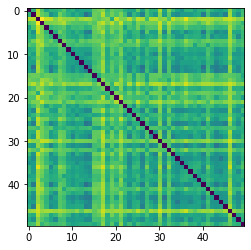

[torch.Size([50, 64, 55, 55]), torch.Size([50, 192, 27, 27]), torch.Size([50, 384, 13, 13]), torch.Size([50, 256, 13, 13]), torch.Size([50, 256, 13, 13]), torch.Size([50, 4096]), torch.Size([50, 4096])]
{'conv1': array([[0.        , 1.8256644 , 1.73828097, ..., 1.43102579, 1.7838614 ,
        2.10466598],
       [1.8256644 , 0.        , 1.8428402 , ..., 1.62927662, 1.99551557,
        1.88261636],
       [1.73828097, 1.8428402 , 0.        , ..., 1.86859117, 2.01404149,
        1.82063206],
       ...,
       [1.43102579, 1.62927662, 1.86859117, ..., 0.        , 1.60360192,
        2.10341926],
       [1.7838614 , 1.99551557, 2.01404149, ..., 1.60360192, 0.        ,
        1.98415609],
       [2.10466598, 1.88261636, 1.82063206, ..., 2.10341926, 1.98415609,
        0.        ]]), 'conv2': array([[0.        , 1.85480426, 1.76538042, ..., 1.94012944, 1.67870882,
        1.72002024],
       [1.85480426, 0.        , 1.90199902, ..., 2.02951828, 1.95083367,
        1.8291413 ],
       [1.76

In [ ]:
#@title Get RDM
module_filter_fn = lambda module, name: isinstance(module, torch.nn.ReLU) 
model = tx.Extractor(model, module_filter_fn=module_filter_fn)
#model = tx.Extractor(model, ["layer1", "layer2", "layer3", "layer4"])
model_output, features = model(input_batch)

from scipy import spatial
for key in features.keys():
  if features[key].ndim >2:
    img = np.average(features[key].detach().numpy(), axis=1)
    img2d = img.reshape(img.shape[0], img.shape[1]*img.shape[2])

  else:
    img2d = features[key].detach().numpy()
  
  dist = spatial.distance.pdist(img2d)
  print (key)
  plt.imshow(spatial.distance.squareform(dist))
  plt.show()


dims=[f.shape for name, f in features.items()]
print(dims)
RDMs = [RDM(f) for name, f in features.items()]
names=["conv1","conv2","conv3","conv4","conv5","linear1","linear2"]
RDMs={names[i]:RDMs[i] for i in range(7)}
print(RDMs)

[[0.                nan        nan ...        nan        nan        nan]
 [1.79903695 0.                nan ...        nan        nan        nan]
 [1.86582519 1.78962597 0.         ...        nan        nan        nan]
 ...
 [1.79366902 1.82063307 1.90434071 ... 0.                nan        nan]
 [1.99465587 1.65123545 1.90153473 ... 1.89663346 0.                nan]
 [1.82291962 1.85885734 1.84997865 ... 1.91815543 1.8237888  0.        ]]


Text(0, 0.5, 'Average Euclidean distance')

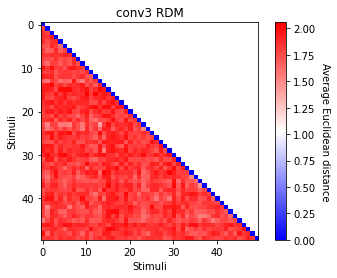

In [ ]:
#@title Visualize RDM
layer_name = 'conv3' #@param ["conv1","conv2","conv3","conv4","conv5","linear1","linear2"]

ROI_RDM = RDMs[layer_name]
print(ROI_RDM)
# Since the matrix is symmetric we set upper triangular values to NaN
ROI_RDM[np.triu_indices(ROI_RDM.shape[0], 1)] = np.nan

# plot the RDM
plt.imshow(ROI_RDM,cmap="bwr")
plt.title(layer_name + " RDM")
cbar = plt.colorbar()
plt.xlabel("Stimuli")
plt.ylabel("Stimuli")
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Average Euclidean distance', rotation=270)